In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Val.csv
/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Train.xlsx
/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Test.csv
/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Test.xlsx
/kaggle/input/covid19-fake-news-dataset-nlp/english_test_with_labels.csv
/kaggle/input/covid19-fake-news-dataset-nlp/test_ernie2.0_results.csv
/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Train.csv


In [2]:
%matplotlib inline
%config InlineBacken.figure_format='svg'

In [3]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import nltk
import torch
import emoji
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
Train = pd.read_csv('/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Train.csv')
Test = pd.read_csv('/kaggle/input/covid19-fake-news-dataset-nlp/english_test_with_labels.csv')
Val = pd.read_csv('/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Val.csv')

In [6]:
Data , Target = Train['tweet'],Train['label']
Data_Val , Target_Val = Val['tweet'],Val['label']
Data_Test, Target_Test = Test['tweet'],Test['label']

In [7]:
Target.replace({'fake':0,'real':1},inplace=True)
Target_Val.replace({'fake':0,'real':1},inplace=True)
Target_Test.replace({'fake':0,'real':1},inplace=True)

/tmp/ipykernel_34/1403732814.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Target.replace({'fake':0,'real':1},inplace=True)
/tmp/ipykernel_34/1403732814.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Target_Val.replace({'fake':0,'real':1},inplace=True)
/tmp/ipykernel_34/1403732814.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option(

In [8]:
class_name = ['fake','real']
Fake_C,Real_C= Target.value_counts().sort_index()
class_C = [Fake_C,Real_C]

Text(0.5, 1.0, 'Class Distribution in Training Data \n Total Count of Samples: 6420')

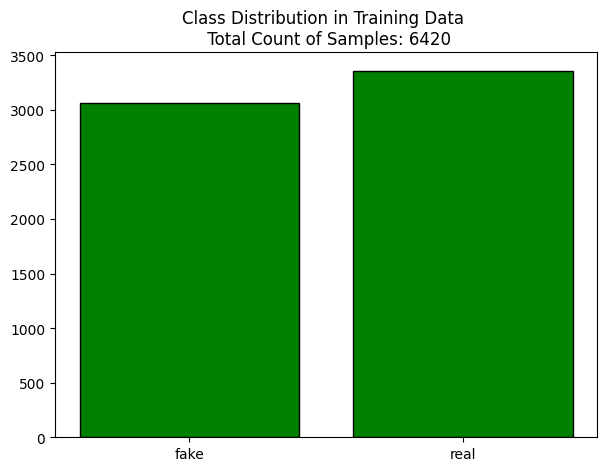

In [9]:
plt.figure(figsize=[7,5])
plt.bar(class_name,class_C, color='green', edgecolor='black')
plt.title(f'Class Distribution in Training Data \n Total Count of Samples: {sum(class_C)}')


([<matplotlib.patches.Wedge at 0x7e7b1005bf10>,
 [Text(0.08066937740569671, 1.097038035598118, 'fake'),
  Text(-0.08066937740569662, -1.097038035598118, 'real')],
 [Text(0.04400147858492548, 0.5983843830535188, '48%'),
  Text(-0.04400147858492542, -0.5983843830535188, '52%')])

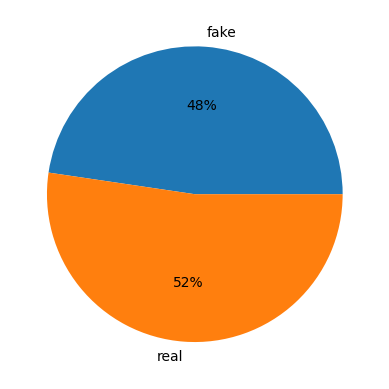

In [10]:
plt.pie(class_C,labels=class_name, autopct='%.0f%%')

In [11]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import nltk
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [13]:
def pre_prosse(x):
  teewt = []
  lemmatizer = WordNetLemmatizer()
  x = x.lower()
  x = emoji.demojize(x)
  url_pattern = re.compile(r'http\S+|www\S+|https\S+')
  x = url_pattern.sub(r'', x)
  x = re.sub(r'[^\w\s]',' ',x)
  x = re.sub(r'\d+', '', x)
  x = word_tokenize(x)
  x = [token for token in x if token not in stop_words]

  for i in x:
    teewt.append(lemmatizer.lemmatize(i))

  return teewt

In [14]:
pre_prosse(Data[200])

['coronavirusupdates',
 'round_pushpin',
 'total',
 'covid',
 'case',
 'india',
 'september',
 'play_button',
 'cured',
 'discharged',
 'migrated',
 'play_button',
 'active',
 'case',
 'play_button',
 'death',
 'total',
 'covid',
 'confirmed',
 'case',
 'cured',
 'discharged',
 'migrated',
 'active',
 'case',
 'death']

In [15]:
def preprosses(X):
    pre_Data = []
    for tweet in X:
        tokens = pre_prosse(tweet)
        joined_tokens = ' '.join(tokens)
        pre_Data.append(joined_tokens)
    return pre_Data
        

In [16]:
pre_Data = preprosses(Data)
pre_Data_Val = preprosses(Data_Val)
pre_Data_Test = preprosses(Data_Test)

In [17]:
def wordcloud(X,Y):
  wordcloud = WordCloud(width = 800, height = 800,background_color ='black',min_font_size = 7).generate(X)
  plt.figure(figsize = (8, 8))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(f'{Y}',fontsize = 30)
  plt.tight_layout(pad = 0)
  plt.show()
  plt.close

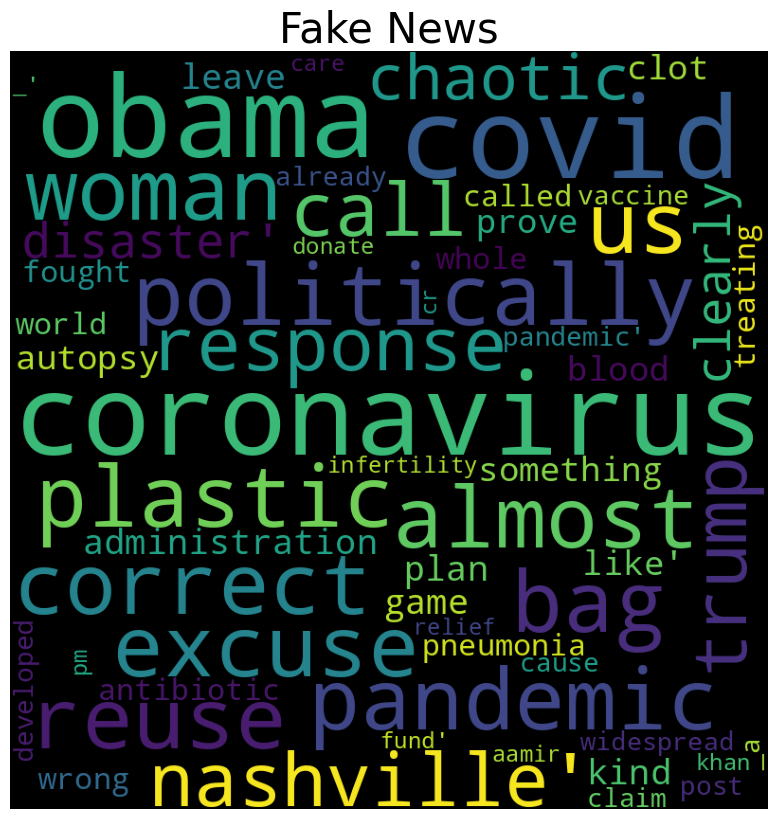

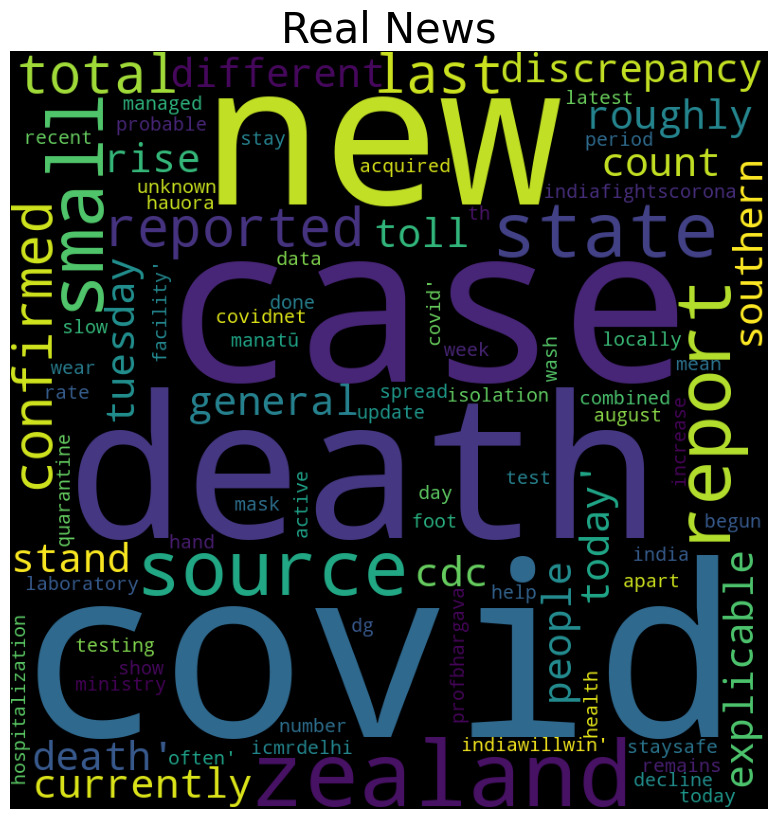

In [18]:
wordcloud(str(np.array(pre_Data)[np.where(np.array(Target) == 0)[0]]),'Fake News')
print('\n')
wordcloud(str(np.array(pre_Data)[np.where(np.array(Target) == 1)[0]]),'Real News')

In [19]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset

In [20]:
def tokenizer_F(X):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  inputs = tokenizer(X, padding=True,truncation=True, return_tensors="pt",max_length=128)
  input_ids = inputs["input_ids"]
  attention_mask = inputs["attention_mask"]
  return input_ids,attention_mask

In [21]:
input_ids_train,attention_mask_train= tokenizer_F(pre_Data)
input_ids_Val,attention_mask_Val= tokenizer_F(pre_Data_Val)
input_ids_Test,attention_mask_Test= tokenizer_F(pre_Data_Test)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
batch_size = 4

dataset_train = TensorDataset(input_ids_train, attention_mask_train,torch.tensor(Target))
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_Val = TensorDataset(input_ids_Val, attention_mask_Val,torch.tensor(Target_Val))
dataloader_Val = DataLoader(dataset_Val, batch_size=200, shuffle=True)

dataset_Test = TensorDataset(input_ids_Test, attention_mask_Test,torch.tensor(Target_Test))
dataloader_Test = DataLoader(dataset_Test, batch_size=200, shuffle=True)

In [23]:
class BertBiGRUF(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, n_layers):
        super(BertBiGRUF, self).__init__()
        self.bert = bert_model
        
        for param in self.bert.parameters():
            param.requires_grad = False
                
        self.bigru = nn.GRU(bert_model.config.hidden_size, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.activ = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embedded = self.bert(input_ids, attention_mask=attention_mask)[0]
            
        gru_output, hidden = self.bigru(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.activ(self.fc(hidden))
        return output


In [24]:
class BertBiGRUT(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, n_layers):
        super(BertBiGRUT, self).__init__()
        self.bert = bert_model      
        self.bigru = nn.GRU(bert_model.config.hidden_size, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.activ = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        embedded = self.bert(input_ids, attention_mask=attention_mask)[0] 
        gru_output, hidden = self.bigru(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.activ(self.fc(hidden))
        return output


In [25]:
class BertDenseF(nn.Module):
    def __init__(self, bert_model, output_dim):
        super(BertDenseF, self).__init__()
        self.bert = bert_model
        
        for param in self.bert.parameters():
            param.requires_grad = False
                
        self.fc = nn.Linear( bert_model.config.hidden_size, output_dim)
        self.activ = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embedded = self.bert(input_ids, attention_mask=attention_mask)[0][:, 0, :]
            
        output = self.activ(self.fc(embedded))
        return output


In [26]:
class BertDenseT(nn.Module):
    def __init__(self, bert_model, output_dim):
        super(BertDenseT, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(bert_model.config.hidden_size, output_dim)
        self.activ = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        embedded = self.bert(input_ids, attention_mask=attention_mask)[0][:, 0, :]
        output = self.activ(self.fc(embedded))
        return output


In [27]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def train_and_evaluate(model, criterion, optimizer, dataloader_train, dataloader_val, num_epochs, device):
    train_losses = []
    train_accuracies = []
    train_recalls = []
    train_f1s = []
    train_precisions = []

    val_losses = []
    val_accuracies = []
    val_recalls = []
    val_f1s = []
    val_precisions = []

    for epoch in range(num_epochs):
        print('===========================')
        epoch_loss = 0.0
        true_labels = []
        predicted_labels = []
        batch_number = 0

        model.train()
        for batch in dataloader_train:
            batch_number += 1
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.view((labels.shape[0], 1)).to(device).type(torch.float)
            true_labels.extend(labels.cpu().numpy())

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_number % 250 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], batch: {batch_number}, Batch loss: {loss.item():.4f}")

            predicted = outputs.data
            predicted_labels.extend((predicted.cpu().numpy() > 0.5).astype(int))
            epoch_loss += loss.item()

        predicted_labels = np.array(predicted_labels).flatten()
        true_labels = np.array(true_labels).flatten()

        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='macro')
        recall = recall_score(true_labels, predicted_labels, average='macro')
        f1 = f1_score(true_labels, predicted_labels, average='macro')

        train_losses.append(epoch_loss / len(dataloader_train))
        train_accuracies.append(accuracy)
        train_precisions.append(precision)
        train_recalls.append(recall)
        train_f1s.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}, Precision: {train_precisions[-1]:.4f}, Recall: {train_recalls[-1]:.4f}, F1 Score: {train_f1s[-1]:.4f}")
        print('++++++++++++++++++++++++++++++++++++')

        model.eval()
        val_loss = 0.0
        val_true_labels = []
        val_predicted_labels = []

        with torch.no_grad():
            for batch in dataloader_val:
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.view((labels.shape[0], 1)).to(device).type(torch.float)
                val_true_labels.extend(labels.cpu().numpy())

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = outputs.data
                val_predicted_labels.extend((predicted.cpu().numpy() > 0.5).astype(int))

            val_predicted_labels = np.array(val_predicted_labels).flatten()
            val_true_labels = np.array(val_true_labels).flatten()

            val_accuracy = accuracy_score(val_true_labels, val_predicted_labels)
            val_precision = precision_score(val_true_labels, val_predicted_labels, average='macro')
            val_recall = recall_score(val_true_labels, val_predicted_labels, average='macro')
            val_f1 = f1_score(val_true_labels, val_predicted_labels, average='macro')

            val_losses.append(val_loss / len(dataloader_val))
            val_accuracies.append(val_accuracy)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            val_precisions.append(val_precision)

            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}, Validation Precision: {val_precisions[-1]:.4f}, Validation Recall: {val_recalls[-1]:.4f}, Validation F1 Score: {val_f1s[-1]:.4f}")

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'train_precisions': train_precisions,
        'train_recalls': train_recalls,
        'train_f1s': train_f1s,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'val_f1s': val_f1s
    }




In [28]:
def plot(num_epochs,Value):
    
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, num_epochs + 1), Value['train_losses'], label='Training Loss')
    plt.plot(range(1, num_epochs + 1), Value['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print('\n')
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, num_epochs + 1), Value['train_accuracies'], label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), Value['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    print('\n')
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, num_epochs + 1), Value['train_recalls'], label='Training Recall')
    plt.plot(range(1, num_epochs + 1), Value['val_recalls'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()
    print('\n')
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, num_epochs + 1), Value['train_f1s'], label='Training F1 Score')
    plt.plot(range(1, num_epochs + 1), Value['val_f1s'], label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    print('\n')
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, num_epochs + 1), Value['train_precisions'], label='Training Precisions Score')
    plt.plot(range(1, num_epochs + 1), Value['val_precisions'], label='Validation Precisions Score')
    plt.xlabel('Epochs')
    plt.ylabel('Precisions Score')
    plt.legend()
    plt.show()

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_F(model,dataloader_test,class_name):
  with torch.no_grad():
    true_labels = []
    predicted_labels = []
    for batch in dataloader_test:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.view((labels.shape[0], 1)).to(device)
        true_labels.extend(labels.cpu().numpy())

        outputs = model(input_ids, attention_mask)
        predicted = outputs.data
        predicted_labels.extend((predicted.cpu().numpy() > 0.5).astype(int))

    predicted_labels = np.array(predicted_labels).flatten()
    true_labels = np.array(true_labels).flatten()
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Test Accuracy: {accuracy:.4f}, Test Precisions: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1:.4f}")
    cm = confusion_matrix(y_true = true_labels,y_pred = predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_name)
    disp.plot()
    return true_labels,predicted_labels


In [30]:
bert_model = BertModel.from_pretrained('google-bert/bert-base-uncased')
CT_bert_model = BertModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert')
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

num_epochs = 5
hidden_dim = 128
output_dim = 1
n_layers = 1

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch [1/5], batch: 250, Batch loss: 0.7293
Epoch [1/5], batch: 500, Batch loss: 0.6813
Epoch [1/5], batch: 750, Batch loss: 0.6423
Epoch [1/5], batch: 1000, Batch loss: 0.5579
Epoch [1/5], batch: 1250, Batch loss: 0.6028
Epoch [1/5], batch: 1500, Batch loss: 0.6513
Epoch [1/5], Loss: 0.6588, Accuracy: 0.6651, Precision: 0.6684, Recall: 0.6675, F1 Score: 0.6650
++++++++++++++++++++++++++++++++++++
Epoch [1/5], Validation Loss: 0.6194, Validation Accuracy: 0.7841, Validation Precision: 0.7932, Validation Recall: 0.7796, Validation F1 Score: 0.7802
Epoch [2/5], batch: 250, Batch loss: 0.5965
Epoch [2/5], batch: 500, Batch loss: 0.5704
Epoch [2/5], batch: 750, Batch loss: 0.7576
Epoch [2/5], batch: 1000, Batch loss: 0.5962
Epoch [2/5], batch: 1250, Batch loss: 0.6155
Epoch [2/5], batch: 1500, Batch loss: 0.5586
Epoch [2/5], Loss: 0.6012, Accuracy: 0.7869, Precision: 0.7946, Recall: 0.7827, F1 Score: 0.7835
++++++++++++++++++++++++++++++++++++
Epoch [2/5], Validation Loss: 0.5653, Validati

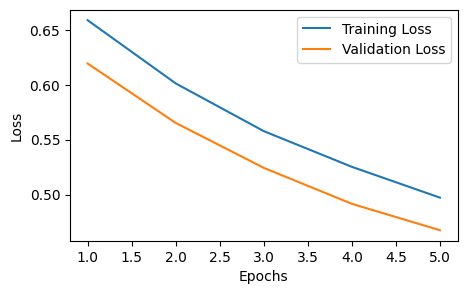

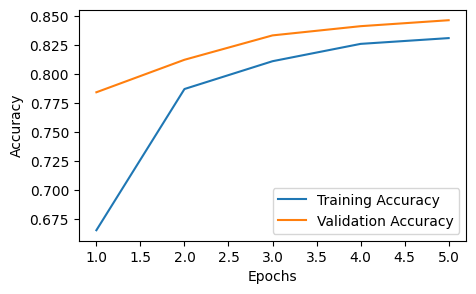

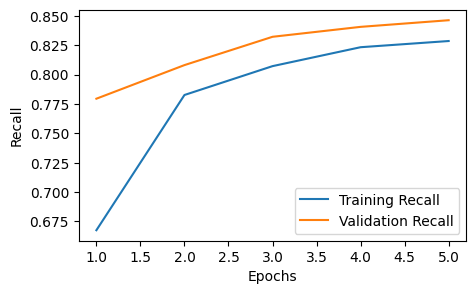

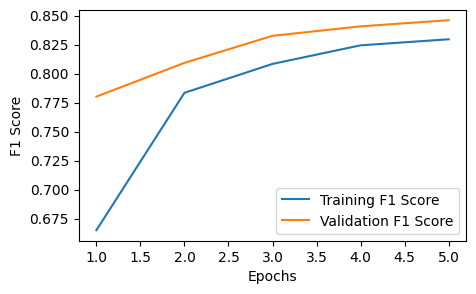

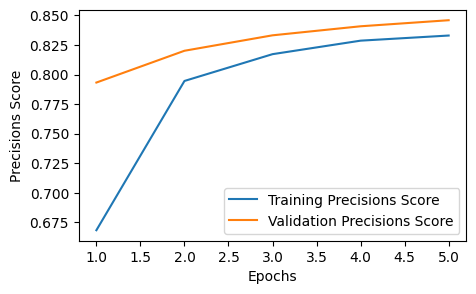

Test Accuracy: 0.8425, Test Precisions: 0.8518, Test Recall: 0.8464, Test F1 Score: 0.8491


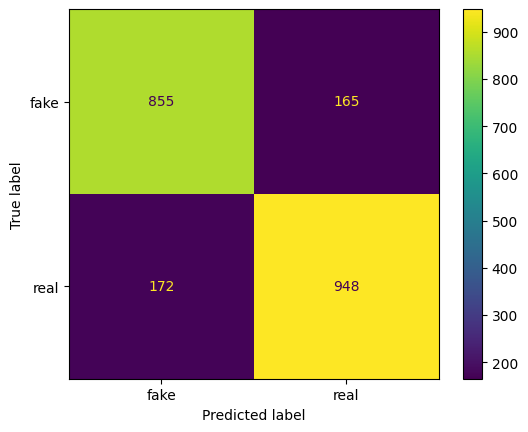

In [34]:
model = BertDenseF(bert_model,output_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

value = train_and_evaluate(model, criterion, optimizer, dataloader_train, dataloader_Val, num_epochs, device)
plot(num_epochs,value)
true_labels1,predicted_labels1 = test_F(model,dataloader_Test,class_name)


Epoch [1/5], batch: 250, Batch loss: 0.5147
Epoch [1/5], batch: 500, Batch loss: 0.4795
Epoch [1/5], batch: 750, Batch loss: 0.4133
Epoch [1/5], batch: 1000, Batch loss: 0.5065
Epoch [1/5], batch: 1250, Batch loss: 0.3089
Epoch [1/5], batch: 1500, Batch loss: 0.2912
Epoch [1/5], Loss: 0.4866, Accuracy: 0.7919, Precision: 0.8031, Recall: 0.7870, F1 Score: 0.7877
++++++++++++++++++++++++++++++++++++
Epoch [1/5], Validation Loss: 0.3270, Validation Accuracy: 0.8715, Validation Precision: 0.8728, Validation Recall: 0.8700, Validation F1 Score: 0.8708
Epoch [2/5], batch: 250, Batch loss: 0.1704
Epoch [2/5], batch: 500, Batch loss: 0.6846
Epoch [2/5], batch: 750, Batch loss: 0.8293
Epoch [2/5], batch: 1000, Batch loss: 0.2098
Epoch [2/5], batch: 1250, Batch loss: 0.0393
Epoch [2/5], batch: 1500, Batch loss: 0.0565
Epoch [2/5], Loss: 0.3017, Accuracy: 0.8782, Precision: 0.8779, Recall: 0.8780, F1 Score: 0.8779
++++++++++++++++++++++++++++++++++++
Epoch [2/5], Validation Loss: 0.2866, Validati

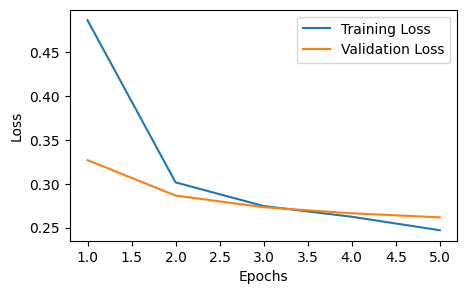

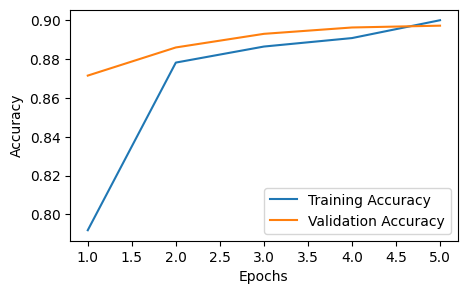

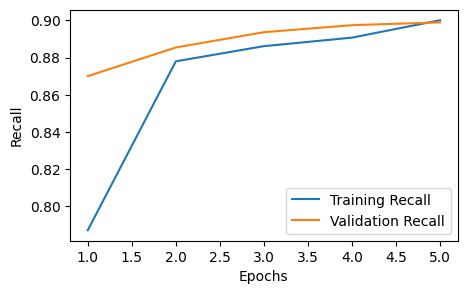

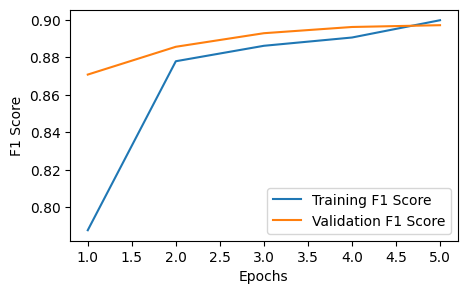

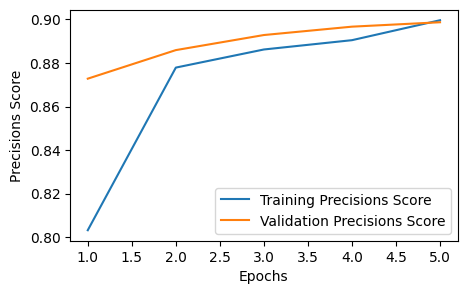

Test Accuracy: 0.8897, Test Precisions: 0.9275, Test Recall: 0.8562, Test F1 Score: 0.8904


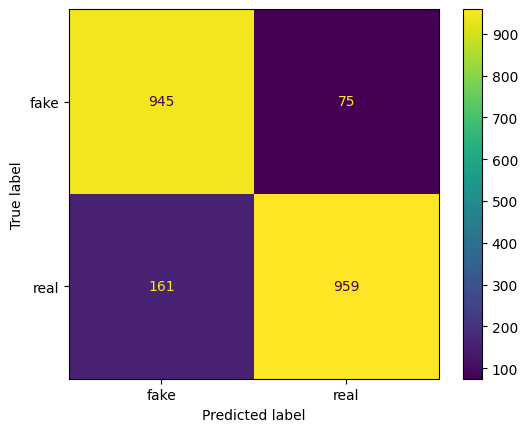

In [35]:
model = BertBiGRUF(bert_model, hidden_dim, output_dim, n_layers).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

value = train_and_evaluate(model, criterion, optimizer, dataloader_train, dataloader_Val, num_epochs, device)
plot(num_epochs,value)
true_labels2,predicted_labels2 = test_F(model,dataloader_Test,class_name)


Epoch [1/5], batch: 250, Batch loss: 0.6269
Epoch [1/5], batch: 500, Batch loss: 0.5251
Epoch [1/5], batch: 750, Batch loss: 0.5464
Epoch [1/5], batch: 1000, Batch loss: 0.3032
Epoch [1/5], batch: 1250, Batch loss: 0.4982
Epoch [1/5], batch: 1500, Batch loss: 0.3163
Epoch [1/5], Loss: 0.5240, Accuracy: 0.7668, Precision: 0.7749, Recall: 0.7623, F1 Score: 0.7626
++++++++++++++++++++++++++++++++++++
Epoch [1/5], Validation Loss: 0.3843, Validation Accuracy: 0.8626, Validation Precision: 0.8627, Validation Recall: 0.8635, Validation F1 Score: 0.8626
Epoch [2/5], batch: 250, Batch loss: 0.2434
Epoch [2/5], batch: 500, Batch loss: 0.3879
Epoch [2/5], batch: 750, Batch loss: 0.1213
Epoch [2/5], batch: 1000, Batch loss: 0.5410
Epoch [2/5], batch: 1250, Batch loss: 0.2101
Epoch [2/5], batch: 1500, Batch loss: 0.2328
Epoch [2/5], Loss: 0.3218, Accuracy: 0.8782, Precision: 0.8778, Recall: 0.8783, F1 Score: 0.8780
++++++++++++++++++++++++++++++++++++
Epoch [2/5], Validation Loss: 0.2742, Validati

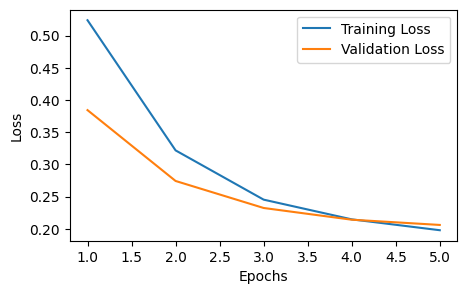

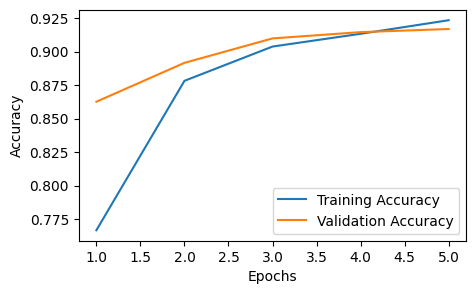

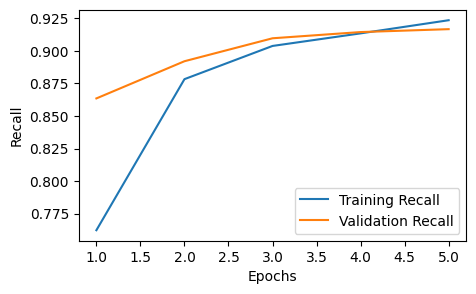

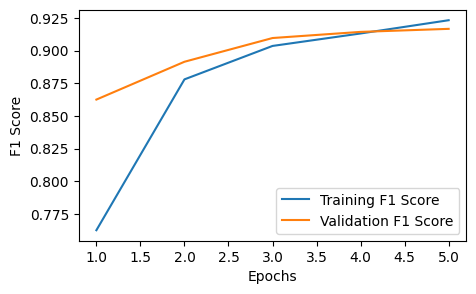

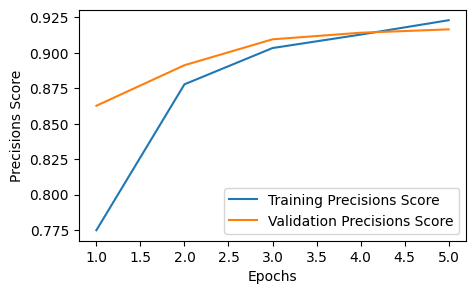

Test Accuracy: 0.9126, Test Precisions: 0.9132, Test Recall: 0.9205, Test F1 Score: 0.9169


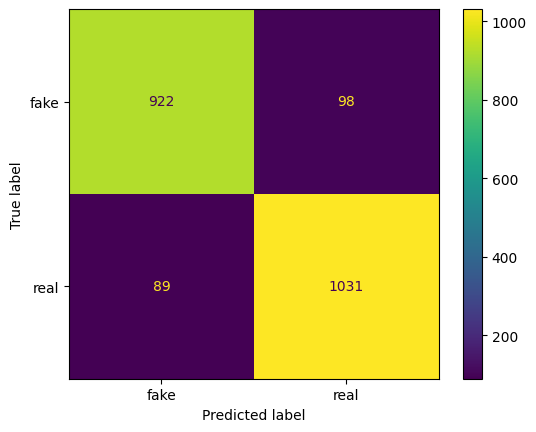

In [36]:
model = BertBiGRUF(CT_bert_model, hidden_dim, output_dim, n_layers).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

value = train_and_evaluate(model, criterion, optimizer, dataloader_train, dataloader_Val, num_epochs, device)
plot(num_epochs,value)
true_labels3,predicted_labels3 = test_F(model,dataloader_Test,class_name)


In [37]:
bert_model = BertModel.from_pretrained('google-bert/bert-base-uncased')

Epoch [1/5], batch: 250, Batch loss: 0.0396
Epoch [1/5], batch: 500, Batch loss: 0.0579
Epoch [1/5], batch: 750, Batch loss: 0.0213
Epoch [1/5], batch: 1000, Batch loss: 0.0435
Epoch [1/5], batch: 1250, Batch loss: 0.0167
Epoch [1/5], batch: 1500, Batch loss: 0.0982
Epoch [1/5], Loss: 0.2444, Accuracy: 0.9003, Precision: 0.9000, Recall: 0.9003, F1 Score: 0.9001
++++++++++++++++++++++++++++++++++++
Epoch [1/5], Validation Loss: 0.1473, Validation Accuracy: 0.9463, Validation Precision: 0.9462, Validation Recall: 0.9461, Validation F1 Score: 0.9461
Epoch [2/5], batch: 250, Batch loss: 0.2137
Epoch [2/5], batch: 500, Batch loss: 0.0959
Epoch [2/5], batch: 750, Batch loss: 0.0007
Epoch [2/5], batch: 1000, Batch loss: 0.0243
Epoch [2/5], batch: 1250, Batch loss: 0.0058
Epoch [2/5], batch: 1500, Batch loss: 0.0125
Epoch [2/5], Loss: 0.1023, Accuracy: 0.9656, Precision: 0.9653, Recall: 0.9658, F1 Score: 0.9655
++++++++++++++++++++++++++++++++++++
Epoch [2/5], Validation Loss: 0.1572, Validati

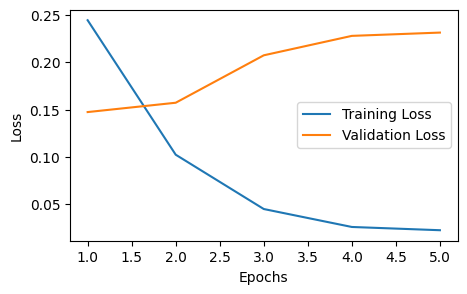

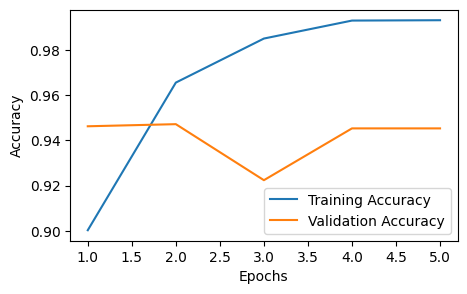

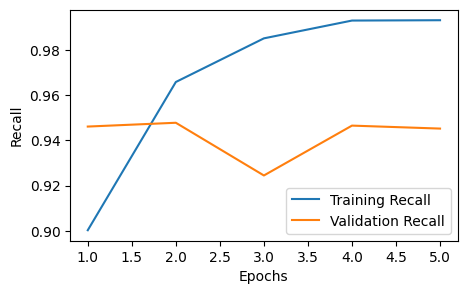

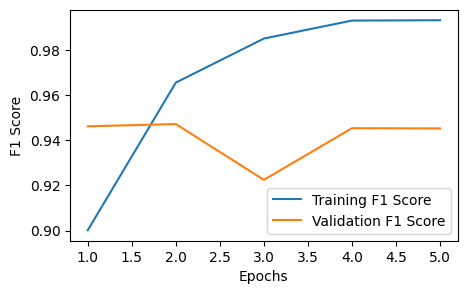

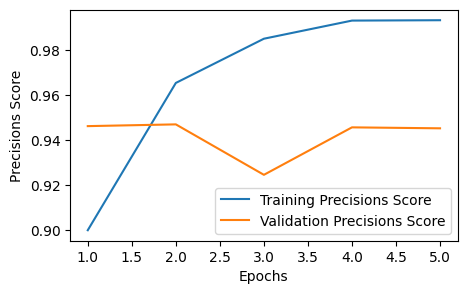

Test Accuracy: 0.9486, Test Precisions: 0.9485, Test Recall: 0.9536, Test F1 Score: 0.9510


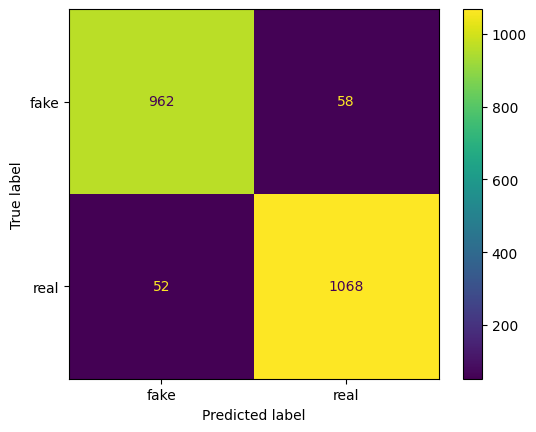

In [38]:
model = BertDenseT(bert_model, output_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

value = train_and_evaluate(model, criterion, optimizer, dataloader_train, dataloader_Val, num_epochs, device)
plot(num_epochs,value)
true_labels4,predicted_labels4 = test_F(model,dataloader_Test,class_name)


In [39]:
bert_model = BertModel.from_pretrained('google-bert/bert-base-uncased')

Epoch [1/5], batch: 250, Batch loss: 0.4955
Epoch [1/5], batch: 500, Batch loss: 0.1355
Epoch [1/5], batch: 750, Batch loss: 0.3132
Epoch [1/5], batch: 1000, Batch loss: 0.1152
Epoch [1/5], batch: 1250, Batch loss: 0.2324
Epoch [1/5], batch: 1500, Batch loss: 0.2627
Epoch [1/5], Loss: 0.2454, Accuracy: 0.8991, Precision: 0.8987, Recall: 0.8993, F1 Score: 0.8989
++++++++++++++++++++++++++++++++++++
Epoch [1/5], Validation Loss: 0.2044, Validation Accuracy: 0.9271, Validation Precision: 0.9327, Validation Recall: 0.9247, Validation F1 Score: 0.9264
Epoch [2/5], batch: 250, Batch loss: 0.0487
Epoch [2/5], batch: 500, Batch loss: 0.0039
Epoch [2/5], batch: 750, Batch loss: 0.0075
Epoch [2/5], batch: 1000, Batch loss: 0.0761
Epoch [2/5], batch: 1250, Batch loss: 0.0047
Epoch [2/5], batch: 1500, Batch loss: 0.0229
Epoch [2/5], Loss: 0.0930, Accuracy: 0.9670, Precision: 0.9668, Recall: 0.9671, F1 Score: 0.9669
++++++++++++++++++++++++++++++++++++
Epoch [2/5], Validation Loss: 0.1707, Validati

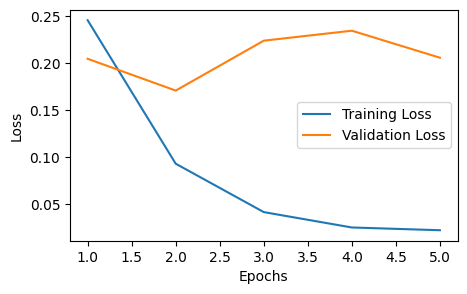

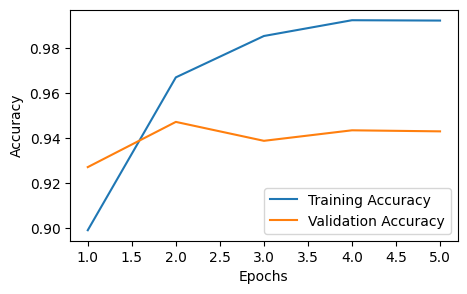

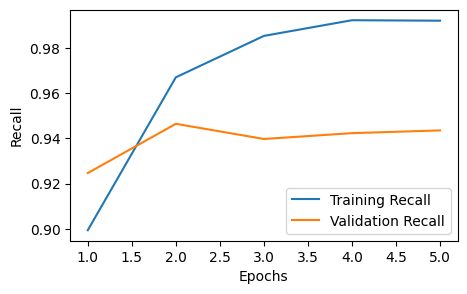

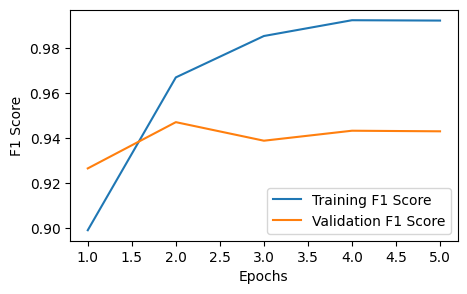

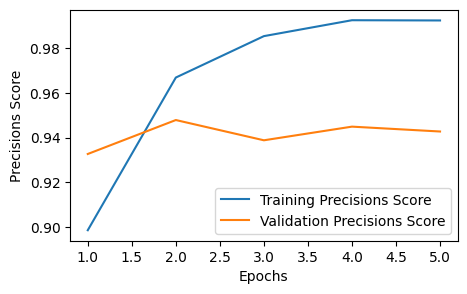

Test Accuracy: 0.9421, Test Precisions: 0.9560, Test Recall: 0.9321, Test F1 Score: 0.9439


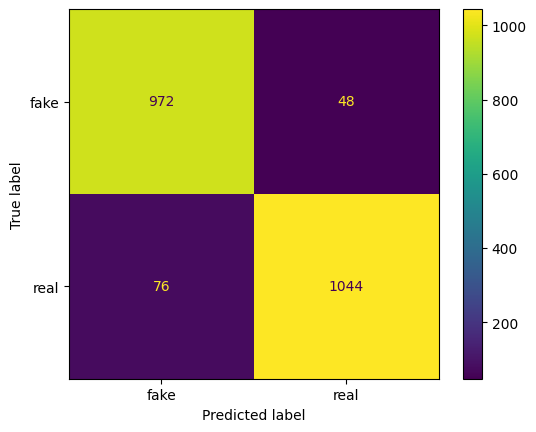

In [40]:
model = BertBiGRUT(bert_model, hidden_dim, output_dim, n_layers).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

value = train_and_evaluate(model, criterion, optimizer, dataloader_train, dataloader_Val, num_epochs, device)
plot(num_epochs,value)
true_labels5,predicted_labels5 = test_F(model,dataloader_Test,class_name)


In [41]:
CT_bert_model = BertModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert')

Epoch [1/5], batch: 250, Batch loss: 0.3795
Epoch [1/5], batch: 500, Batch loss: 0.2449
Epoch [1/5], batch: 750, Batch loss: 0.0237
Epoch [1/5], batch: 1000, Batch loss: 0.0131
Epoch [1/5], batch: 1250, Batch loss: 0.4499
Epoch [1/5], batch: 1500, Batch loss: 0.0065
Epoch [1/5], Loss: 0.1795, Accuracy: 0.9304, Precision: 0.9302, Recall: 0.9303, F1 Score: 0.9302
++++++++++++++++++++++++++++++++++++
Epoch [1/5], Validation Loss: 0.1275, Validation Accuracy: 0.9533, Validation Precision: 0.9543, Validation Recall: 0.9524, Validation F1 Score: 0.9531
Epoch [2/5], batch: 250, Batch loss: 0.0306
Epoch [2/5], batch: 500, Batch loss: 0.0078
Epoch [2/5], batch: 750, Batch loss: 0.0023
Epoch [2/5], batch: 1000, Batch loss: 0.1943
Epoch [2/5], batch: 1250, Batch loss: 0.0012
Epoch [2/5], batch: 1500, Batch loss: 0.0312
Epoch [2/5], Loss: 0.0523, Accuracy: 0.9830, Precision: 0.9830, Recall: 0.9830, F1 Score: 0.9830
++++++++++++++++++++++++++++++++++++
Epoch [2/5], Validation Loss: 0.1265, Validati

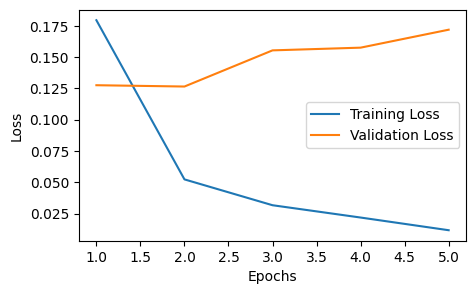

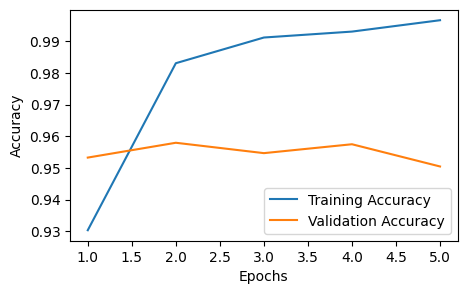

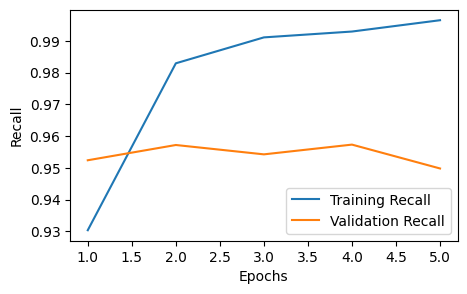

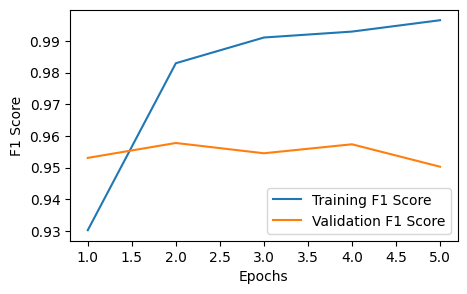

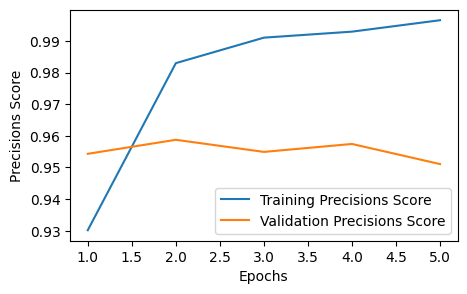

Test Accuracy: 0.9556, Test Precisions: 0.9484, Test Recall: 0.9679, Test F1 Score: 0.9580


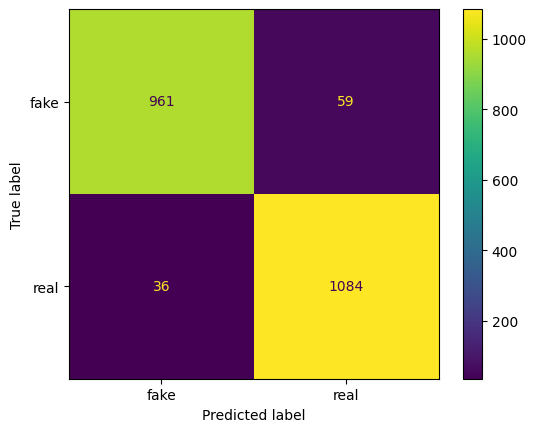

In [42]:
model = BertBiGRUT(CT_bert_model, hidden_dim, output_dim, n_layers).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

value = train_and_evaluate(model, criterion, optimizer, dataloader_train, dataloader_Val, num_epochs, device)
plot(num_epochs,value)
true_labels6,predicted_labels6 = test_F(model,dataloader_Test,class_name)


In [122]:
from termcolor import colored # :)

def print_wrong_prediction(true_labels, predicted_labels, Data_Test):
    print('Tweets that are incorrectly predicted: \n')
    for i in range(true_labels.size):
        if true_labels[i] != predicted_labels[i]:
            true_label_colored = colored(f'{class_name[true_labels[i]]}', 'green')
            predicted_label_colored = colored(f'{class_name[predicted_labels[i]]}', 'red')
            print(f'Tweets number: {i} Correct label: {true_label_colored} Predicted label: {predicted_label_colored}   Tweets: {Data_Test[i]} \n')



In [123]:
print_wrong_prediction(true_labels1, predicted_labels1, Data_Test)


Tweets that are incorrectly predicted: 

Tweets number: 13 Correct label: fake Predicted label: real   Tweets: An audio file by an alleged worker at a health institution in Rio de Janeiro. She says that healthcare workers on public institutions in Rio are forced to state whether a patient has COVID-19 or not even before he sees a doctor. This was allegedly being done to artificially inflate the number of cases. 

Tweets number: 28 Correct label: fake Predicted label: real   Tweets: She has been in managed Isolation at the Distinction Hotel in Hamilton and tested positive around day 3 of her stay. ​ We have 13 new confirmed cases in Auckland. They are all linked to the 4 people who we reported as cases yesterday and the day before. 

Tweets number: 29 Correct label: fake Predicted label: real   Tweets: The Gates Foundation "has the patent for this coronavirus." 

Tweets number: 43 Correct label: fake Predicted label: real   Tweets: Flood Hit Areas Pretend To Have Coronavirus In Bid To G

In [124]:
print_wrong_prediction(true_labels2, predicted_labels2, Data_Test)


Tweets that are incorrectly predicted: 

Tweets number: 3 Correct label: real Predicted label: fake   Tweets: States reported 630 deaths. We are still seeing a solid national decline. Death reporting lags approximately 28 days from symptom onset according to CDC models that consider lags in symptoms time in hospital and the death reporting process. https://t.co/LBmcot3h9a 

Tweets number: 12 Correct label: real Predicted label: fake   Tweets: 🇰🇼 Assistant Undersecretary for Public Health Affairs Dr Buthayna Almodaf highlighted the importance of risk communication &amp; public education in fighting #COVID19. The country increased testing capacity enabling 400000 people to be tested. 

Tweets number: 32 Correct label: fake Predicted label: real   Tweets: There are also clear *demand* constraints as testing criteria remain quite strict. We are still getting reports from all over of people who have been able unable to get tested despite having a good reason to do so. 

Tweets number: 39 Co

In [125]:
print_wrong_prediction(true_labels3, predicted_labels3, Data_Test)


Tweets that are incorrectly predicted: 

Tweets number: 0 Correct label: fake Predicted label: real   Tweets: Our daily update is published. States reported 734k tests 39k new cases and 532 deaths. Current hospitalizations fell below 30k for the first time since June 22. https://t.co/wzSYMe0Sht 

Tweets number: 36 Correct label: fake Predicted label: real   Tweets: @LimaEleanor Kia ora Elanor there are currently 21 active cases in New Zealand they were all caught at the border and we have no evidence of community transmission. 

Tweets number: 56 Correct label: real Predicted label: fake   Tweets: On the 15/03 NCDC directly contacted a Twitter user who mentioned his friend who returned from UK had runny nose but could not reach authorities for testing. Within 12 hours of communication with us via DM a sample was collected. We’re committed to doing our best https://t.co/fccdGij3uG 

Tweets number: 67 Correct label: real Predicted label: fake   Tweets: Quotes Joe Biden as saying “people 

In [126]:
print_wrong_prediction(true_labels4, predicted_labels4, Data_Test)


Tweets that are incorrectly predicted: 

Tweets number: 17 Correct label: real Predicted label: fake   Tweets: An image of a man carrying his old mother on his back shows migrants travelling to their homes in India amidst lockdown. 

Tweets number: 69 Correct label: fake Predicted label: real   Tweets: CORRECTION 1/4 On 3rd of April 2020 we reported 26 new cases of #COVID19 in Nigeria. An error has been discovered in this report as follows: ⚫️ There were 25 new cases of #COVID19 in Nigeria. The 26th case was a repeat result of a previously confirmed case and NOT a new case https://t.co/oq2FA6zvpY 

Tweets number: 83 Correct label: real Predicted label: fake   Tweets: #IndiaFightsCorona: India registers a record of highest single day recoveries  More than 1 lakh patients recovered in the last 24 hours #StaySafe #IndiaWillWin https://t.co/QIHLyf4uyp 

Tweets number: 108 Correct label: real Predicted label: fake   Tweets: RT @DepSecHargan: #COVID19 has led to an⬆️in #telehealth services –

In [127]:
print_wrong_prediction(true_labels5, predicted_labels5, Data_Test)


Tweets that are incorrectly predicted: 

Tweets number: 7 Correct label: fake Predicted label: real   Tweets: The government should consider bringing in any new national lockdown rules over Christmas rather than now says an Oxford University professor https://t.co/pdOls6cqoN 

Tweets number: 14 Correct label: real Predicted label: fake   Tweets: Says the Coronavirus Aid, Relief, and Economic Security Act gives members of Congress a pay increase. 

Tweets number: 57 Correct label: real Predicted label: fake   Tweets: A WhatsApp forward has gone viral which claimed that a vaccine for coronavirus has been discovered. The viral forward also claims that the treatment for coronavirus is mentioned in India's Intermediate Zoology book. 

Tweets number: 89 Correct label: real Predicted label: fake   Tweets: 18 states including US UK and Australia request PM Modi to head a task force to stop coronavirus. 

Tweets number: 102 Correct label: fake Predicted label: real   Tweets: @htTweets NOT For C

In [128]:
print_wrong_prediction(true_labels6, predicted_labels6, Data_Test)


Tweets that are incorrectly predicted: 

Tweets number: 10 Correct label: real Predicted label: fake   Tweets: Two interesting correlations:

1) Children tend to weather COVID-19 pretty well; they also get a ton of Vitamin D.

2) Black people are getting slammed by COVID-19; black people also have much higher instances of Vitamin D deficiency (76% vs 40% in the general population). 

Tweets number: 16 Correct label: fake Predicted label: real   Tweets: Households should have "required" medical kits with certain items and equipment to treat the different stages of COVID-19. 

Tweets number: 55 Correct label: fake Predicted label: real   Tweets: As tuberculosis shaped modernism, so COVID-19 and our collective experience of staying inside for months on end will influence architecture’s near future, @chaykak writes. https://t.co/ag34yZckbU 

Tweets number: 61 Correct label: real Predicted label: fake   Tweets: This rise in deaths is concentrated in states with large outbreaks. Texas Califo